In [2]:
import numpy as np

from pathlib import Path

import matplotlib
import matplotlib.pyplot as plt

import pickle

from tqdm import tqdm

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.autograd.functional import jacobian
from torch.autograd.functional import hessian
import torch.optim as optim

In [3]:
def f_analytical(states, t=0, m_1=1, m_2=1, l_1=1, l_2=1, g=9.8):
    """
    The analytical dynamics of the system
    """
    theta_1, theta_2, omega_1, omega_2 = states.T
    
    a_1 = (l_2 / l_1) * (m_2 / (m_1 + m_2)) * np.cos(theta_1 - theta_2)
    a_2 = (l_1 / l_2) * np.cos(theta_1 - theta_2)
    
    
    f_1 = -(l_2 / l_1) * (m_2 / (m_1 + m_2)) * (omega_2**2) * np.sin(theta_1 - theta_2) - (g / l_1) * np.sin(theta_1)
    f_2 = (l_1 / l_2) * (omega_1**2) * np.sin(theta_1 - theta_2) - (g / l_2) * np.sin(theta_2)
    g_1 = (f_1 - a_1 * f_2) / (1 - a_1 * a_2)
    g_2 = (f_2 - a_2 * f_1) / (1 - a_1 * a_2)
    
    return np.array([omega_1, omega_2, g_1, g_2]).T


def rk4_step(f, x, t, tau):
    """
    One step of runge-kutta integration f(x, t)
    """
    k_1 = tau * f(x, tau)
    k_2 = tau * f(x + k_1/2, t + tau/2)
    k_3 = tau * f(x + k_2/2, t + tau/2)
    k_4 = tau * f(x + k_3, t + tau)
    
    return x + 1/6 * (k_1 + 2 * k_2 + 2 * k_3 + k_4)


def rk4_step_rectified(f, x, t, tau, model):
    """
    One step of runge-kutta integration f(x)
    """    
    k_1 = tau * f(x, model)
    k_2 = tau * f(x + k_1/2, model)
    k_3 = tau * f(x + k_2/2, model)
    k_4 = tau * f(x + k_3, model)
    
    return x + 1/6 * (k_1 + 2 * k_2 + 2 * k_3 + k_4)

def solve_numerical(f, initial_state, t_arr, tau, model, solver=rk4_step):
    """
    Steps of solver
    """ 
    states = []
    now_state = initial_state
    
    for t in t_arr:
        states.append(now_state)
        next_state = solver(f, now_state, t, tau, model)
        now_state = next_state
    
    return np.array(states)

In [4]:
def radial2cartesian(theta_1, theta_2, l_1, l_2):
    '''
    Convert from radial to cartesian coordinates
    '''
    x_1 = l_1 * np.sin(theta_1)
    y_1 = -l_1 * np.cos(theta_1)
    x_2 = x_1 + l_2 * np.sin(theta_2)
    y_2 = y_1 - l_2 * np.cos(theta_2)
    return x_1, y_1, x_2, y_2

def plot_predicted_trajectory(cart_coords, model_name, save=False, verbose=True):
    """
    Plot predicted trajectory
    """
    _, _, x_2, y_2 = cart_coords
    
    length = len(x_2)
    t = np.arange(length)
    
    plt.title(f"{model_name}" + f"Timeseries - {length} timesteps")

    plt.plot(x_2, y_2, marker='.', color="lightgray", zorder=0)
    plt.scatter(x_2, y_2, marker='o', c=t[:length], cmap="viridis", s=10, zorder=1)

    plt.xlabel("$x$")
    plt.ylabel("$y$")

    cbar = plt.colorbar()
    cbar.ax.set_ylabel('$t$', rotation=270)

    plt.tight_layout()
    if save == True:
        plt.savefig(Path('figures', f'Predicted_trajectory_{model_name}.png'), dpi=150)
    if verbose == True:
        plt.show()

def get_dynamics_coords(states, model_name, save=False, verbose=True):
    """
    Get dynamics coords
    """
    l_1, l_2 = 1, 1
    theta_1, theta_2 = states[:, 0], states[:, 1]
    cart_coords = radial2cartesian(theta_1, theta_2, l_1, l_2)
    plot_predicted_trajectory(cart_coords, model_name=model_name, save=save, verbose=verbose)
    return cart_coords

In [5]:
'''
Parameters
'''
TIME_STEP = 0.01
RANDOM_STATE = 123
N = 2500
n_trajectories = 20
s = 2

In [6]:
"""
Generating trajectories and separation to train and test
"""
time_step = TIME_STEP
t = np.arange(0, time_step * N, time_step) 
np.random.seed(seed = RANDOM_STATE)

initial_angles = np.random.uniform(0, 1, (n_trajectories, 2)) * np.pi
initial_states = np.array([[angle_1, angle_2, 0, 0] for (angle_1, angle_2) in initial_angles])

trajectories = np.array([solve_numerical(f_analytical, initial_state, t, time_step) for initial_state in initial_states])

x_train = trajectories[:, :(4 * N // 5), :].reshape(-1, 2 * s)
x_test = trajectories[:, (4 * N // 5):, :].reshape(-1, 2 * s)

y_train = f_analytical(x_train)
y_test = f_analytical(x_test)

with open(Path("dataset", "data", "train_data_new.pickle"), 'wb') as handle:
    pickle.dump([x_train, y_train], handle, protocol=pickle.HIGHEST_PROTOCOL)
with open(Path("dataset", "data", "test_data_new.pickle"), 'wb') as handle:
    pickle.dump([x_test, y_test], handle, protocol=pickle.HIGHEST_PROTOCOL)

TypeError: solve_numerical() missing 1 required positional argument: 'model'

In [18]:
"""
Uploading a dataset 
"""
class DoublePendulumDataset(Dataset):
    def __init__(self, x_set, y_set):
        self.sample_list = list(zip(x_set, y_set))
        
    def __len__(self):
        return len(self.sample_list)
    
    def transform(state):
        angles = state[:s]
        return np.hstack(((angles + np.pi) % (2 * np.pi) - np.pi, state[s:]))

    def __getitem__(self, idx):
        x_sample, y_sample = self.sample_list[idx]
        x_sample = DoublePendulumDataset.transform(x_sample)
        return x_sample.astype('float32'), y_sample.astype('float32')


with open(Path("dataset", "data", "train_data_new.pickle"), 'rb') as f:
    train_data = pickle.load(f)
with open(Path("dataset", "data", "test_data_new.pickle"), 'rb') as f:
    test_data = pickle.load(f)
    
[x_train, y_train] = train_data
[x_test, y_test] = test_data
    
train_dataset = DoublePendulumDataset(x_train, y_train)
test_dataset = DoublePendulumDataset(x_test, y_test)

In [12]:
class BaselineNN(nn.Module):
    '''
    Neural network
    '''
    def __init__(self, s=2):
        super().__init__()
        
        self.sequence = nn.Sequential(
            nn.Linear(2 * s, 64),
            nn.Softplus(),
            nn.Linear(64, 128),
            nn.Softplus(),
            nn.Linear(128, 1),
        )
     
    def forward(self, x):
        return self.sequence(x)

In [79]:
def train_epoch(model, train_loader, optimizer, verbose=True):
    '''
    Train epoch
    ''' 
    model.train()
    
    loss_func = nn.MSELoss()
    total_loss = 0
    
    for batch in tqdm(train_loader, disable=not verbose):
        coords, targets = batch
        
        preds = torch.zeros((len(targets), 2 * s))
        
        for i, coord in enumerate(coords):
            
            J = jacobian(model, coord, create_graph=True, strict=True)[0]
            J_q = J[:s]
            
            H = hessian(model, coord, create_graph=True, strict=True)
            H_qt_qt = H[s:, s:]
            H_qt_q = H[:s, s:]
            
            q_tt = torch.inverse(H_qt_qt) @ (J_q - H_qt_q @ coord[s:])

            preds[i] = torch.cat((coord[s:], q_tt))
            
        loss = loss_func(preds, targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss
    
    model.eval()
    
    return total_loss / len(train_loader)


def test_epoch(model, test_loader, verbose=True):
    '''
    Train epoch
    '''
    model.eval()
    
    loss_func = nn.MSELoss()
    total_loss = 0
    
    for batch in tqdm(test_loader, disable=not verbose):
        coords, targets = batch

        preds = torch.zeros((len(targets), 2 * s))
        
        for i, coord in enumerate(coords):

            J = jacobian(model, coord)[0]
            J_q = J[:s]
            
            H = hessian(model, coord)
            H_qt_qt = H[s:, s:]
            H_qt_q = H[:s, s:]
            
            q_tt = torch.inverse(H_qt_qt) @ (J_q - H_qt_q @ coord[s:])

            preds[i] = torch.cat((coord[s:], q_tt))

        total_loss += loss_func(preds, targets)

    return total_loss / len(test_loader)


def train_model(model, train_loader, test_loader, num_epochs, lr, verbose=True):
    '''
    Test epoch
    '''
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_losses = []
    test_losses = []
    
    for epoch in range(num_epochs):
        train_loss = train_epoch(model, train_loader, optimizer, verbose=verbose)
        test_loss = test_epoch(model, test_loader, verbose=verbose)
        train_losses.append(train_loss)
        test_losses.append(test_loss)
        
        if verbose == True:
            print(f'============= Epoch {epoch + 1} =============')
            print(f'train loss: {train_loss}')
            print(f'test loss: {test_loss}')

    return train_losses, test_losses 

In [75]:
BATCH_SIZE = 64
LR = 5e-4
NUM_EPOCHS = 4

In [76]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=BATCH_SIZE)

In [11]:
lnn_model = BaselineNN()

NameError: name 'BaselineNN' is not defined

In [78]:
train_losses, test_losses = train_model(lnn_model, train_loader, test_loader, NUM_EPOCHS, LR)

100%|█████████████████████████████████████████| 157/157 [00:25<00:00,  6.18it/s]


============= Epoch 1 =============
train loss: 274004.875
test loss: 169.3370819091797


100%|█████████████████████████████████████████| 157/157 [00:21<00:00,  7.16it/s]


============= Epoch 2 =============
train loss: 168.6577911376953
test loss: 169.3370819091797


100%|█████████████████████████████████████████| 157/157 [00:22<00:00,  6.89it/s]


============= Epoch 3 =============
train loss: 168.6578826904297
test loss: 169.3370819091797


  3%|█▎                                        | 20/625 [00:06<03:06,  3.24it/s]


KeyboardInterrupt: 

In [9]:
def lagrangian(state):
    """
    Lagrangian of the double pendulum
    """
    t1, t2, w1, w2 = state

    T1 = 0.5 * (w1)**2
    T2 = 0.5 * ((w1)**2 + (w2)**2 + 2 * w1 * w2 * torch.cos(t1 - t2))
    T = T1 + T2

    # potential energy (V)
    y1 = -torch.cos(t1)
    y2 = y1 - torch.cos(t2)
    V = 9.8 * y1 + 9.8 * y2

    return T - V

In [10]:
def f_lnn(state, model = lnn_model):
    '''
    Result of learning lnn
    '''
    state = DoublePendulumDataset.transform(state)
    state = torch.from_numpy(state.astype('float32'))
    
    J = jacobian(model, state)
    J_q = J[:s]
    
    H = hessian(model, state)
    H_qt_qt = H[s:, s:]
    H_qt_q = H[:s, s:]

    q_tt = torch.inverse(H_qt_qt) @ (J_q - H_qt_q @ state[s:])
    
    return torch.cat((state[s:], q_tt)).numpy()

NameError: name 'lnn_model' is not defined

In [16]:
'''
Parameters
'''
k = 2
time_step = TIME_STEP
n = 300
t_arr = np.arange(0, time_step * n, time_step) 

In [20]:
'''
Results
'''
initial_state = initial_states[k]
lagrangian_pred_trajectory = solve_numerical(f_lnn, initial_state, t_arr, time_step, lagrangian, solver=rk4_step_rectified)
#pred_trajectory = solve_numerical(f_lnn, initial_state, t_arr, time_step, lnn_model, solver=rk4_step_rectified)
#print(pred_trajectory[:10])
print(lagrangian_pred_trajectory[:10])
#print(trajectories[k][:10])

[[ 2.26027843  1.32922815  0.          0.        ]
 [ 2.25999119  1.32892384 -0.0574476  -0.06086597]
 [ 2.2591295   1.32801067 -0.11488986 -0.12177851]
 [ 2.25769343  1.32648796 -0.17232135 -0.18278428]
 [ 2.25568312  1.32435452 -0.22973634 -0.24393006]
 [ 2.25309878  1.32160873 -0.28712878 -0.3052628 ]
 [ 2.24994065  1.31824848 -0.34449211 -0.3668297 ]
 [ 2.24620906  1.3142712  -0.40181915 -0.42867832]
 [ 2.24190441  1.30967382 -0.45910199 -0.49085655]
 [ 2.23702719  1.30445281 -0.51633188 -0.55341273]]


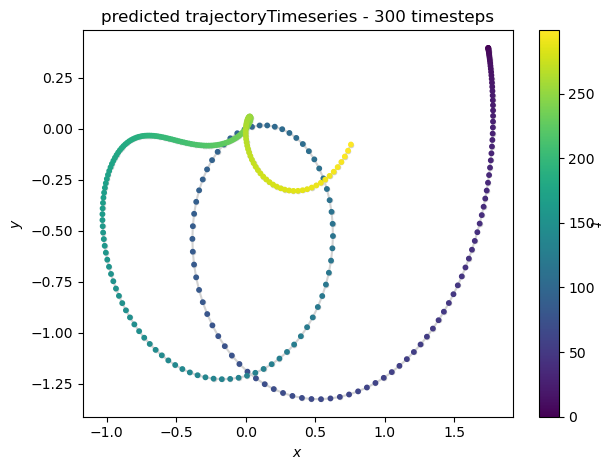

In [22]:
'''
Plots
'''
#_ = get_dynamics_coords(trajectories[k][:n], 'trajectory rk4')
_ = get_dynamics_coords(lagrangian_pred_trajectory, 'predicted trajectory')